In [2]:
%matplotlib notebook
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
from skimage.transform import downscale_local_mean #For binning

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
#sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
#import ddm_analysis_and_fitting as ddm   

import tiff_file 

import io 
import sys
import csv

import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data
### usually this block prints out "nd2reader module not found. Reading of .nd2 files disabled." on the first run
### this is fine (unless you need to read .nd2 files), just re-run this block to make the error go away

In [3]:
### filtimage removes the background 
def filtimage(image, filtersize=600):
    image = (image/100)**1.6 #(array)^1.6 to increase contrast (i think this works?)
    image = (image*10) +1000
    image = (image*1.0) - ((uf(image,filtersize))*1)  #(image) - unifrom-filtered(image) subtracts background
    image = image + 1500  #return pixel array values back to their original range 
    return image

### the following functions ('show_raw_images', and 'show_filtered_images') are used to preview the images intended for analysis
def show_raw_images(row, ax, i, frame_key):
    if row == 1:
        index_add = 0
    if row == 2:
        index_add = arr_length
    if row == 3:
        index_add = arr_length * 2
    test_image = tiff_file.imread(files[i+index_add],key=[frame_key])
    #print(files[i+index_add])
    ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+", fsize=none)", fontsize=10)
    ax.imshow(test_image, cmap = 'gray')
    ax.axis('off')
    plt.tight_layout(pad=.2)

def show_filtered_images(fsize, row, ax, i, frame_key):
    if row == 1:
        index_add = 0
    if row == 2:
        index_add = arr_length
    if row == 3:
        index_add = arr_length * 2
    test_image = tiff_file.imread(files[i+index_add],key=[frame_key])
    #print(files[i+index_add])
    ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+", fsize="+str(fsize)+")", fontsize=10)
    filtered_image = filtimage(test_image, filtersize= fsize)
    fully_processed_image = downscale_local_mean(filtered_image, (2,2), cval=1)
    ax.imshow(fully_processed_image, cmap = 'gray')
    ax.axis('off')
    plt.tight_layout(pad=.2)

In [17]:
directory = "Z"
exp = "10-15-22_s1_theBigOne2"
### "data_dir" is the pathway to the folder holding the tiff files to be analyzed 
data_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\all tiff files\\" 
data_dir2 = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\all times PNGs\\all rows\\" #bottom_row_t01\\

### "plot_saveto" is the pathway to the folder where plots and results will be saved
plot_saveto= directory+":\\Gregor L\\__Kai Colloids\\SIA\\Data\\"+exp+"\\"

files = glob.glob(data_dir+"*_t*") ### this should generate an ordered list of files in "data_dir" which have "_t" in their name
print("found %i files" % len(files))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 54 files
 0 	 row1_t1.tif
 1 	 row1_t2.tif
 2 	 row1_t3.tif
 3 	 row1_t4.tif
 4 	 row1_t5.tif
 5 	 row1_t6.tif
 6 	 row1_t7.tif
 7 	 row1_t8.tif
 8 	 row1_t9.tif
 9 	 row2_t1.tif
 10 	 row2_t2.tif
 11 	 row2_t3.tif
 12 	 row2_t4.tif
 13 	 row2_t5.tif
 14 	 row2_t6.tif
 15 	 row2_t7.tif
 16 	 row2_t8.tif
 17 	 row2_t9.tif
 18 	 row3_t1.tif
 19 	 row3_t2.tif
 20 	 row3_t3.tif
 21 	 row3_t4.tif
 22 	 row3_t5.tif
 23 	 row3_t6.tif
 24 	 row3_t7.tif
 25 	 row3_t8.tif
 26 	 row3_t9.tif
 27 	 row4_t1.tif
 28 	 row4_t2.tif
 29 	 row4_t3.tif
 30 	 row4_t4.tif
 31 	 row4_t5.tif
 32 	 row4_t6.tif
 33 	 row4_t7.tif
 34 	 row4_t8.tif
 35 	 row4_t9.tif
 36 	 row5_t1.tif
 37 	 row5_t2.tif
 38 	 row5_t3.tif
 39 	 row5_t4.tif
 40 	 row5_t5.tif
 41 	 row5_t6.tif
 42 	 row5_t7.tif
 43 	 row5_t8.tif
 44 	 row5_t9.tif
 45 	 row6_t1.tif
 46 	 row6_t2.tif
 47 	 row6_t3.tif
 48 	 row6_t4.tif
 49 	 row6_t5.tif
 50 	 row6_t6.tif
 51 	 row6_t7.tif
 52 	 row6_t8.tif
 53 	 row6_t9.tif


In [11]:
frame_names = ["1-3 kA-WT", "WT (no kA)", "EA KaiC", "AE KaiC"]
### array containing the name for each frame in a tiff file to be run 
### e.g. frame 1 is an image of the "50% bKaiB" condition, frame 2 is an image of the "35% bKaiB" condition, etc.

time_array = [1.2, 4.0, 7.4, 10.3, 14.7, 17.7, 20.3, 23.8, 27.0]  
### array containing the time points corresponding to consecutive tiff files
### e.g. tiff files "bottom_row_t1", "middle_row_t1", and "top_row_t1" all correspond to t = 0.5 hrs, time_array[0]

pixel_size = 0.364 # 4*0.091 = 0.364
### pixel size (microns per pixel) of frames/ images in the tiff files --- 40x olympus objective => 0.091 um/px
### IF 2x2 BINNING: multiply the original pixel size by 2^2 = 4, e.g. 4*(0.091 um/px) = 0.364 um/px

eg_im= tiff_file.imread(files[0])
print("tiff file dimensions: "+ str(eg_im.shape))

arr_length = int((len(files))/6)
print("total number of time points: "+ str(arr_length))

tiff file dimensions: (5, 1440, 1920)
total number of time points: 9


In [12]:
fig_size = 10,10/1.618
###  size of output figures
font_size = 16
### font size
dpi_num = 800
### image quality level (recommendation: 600)

condition: 1-3 kA-WT


<IPython.core.display.Javascript object>


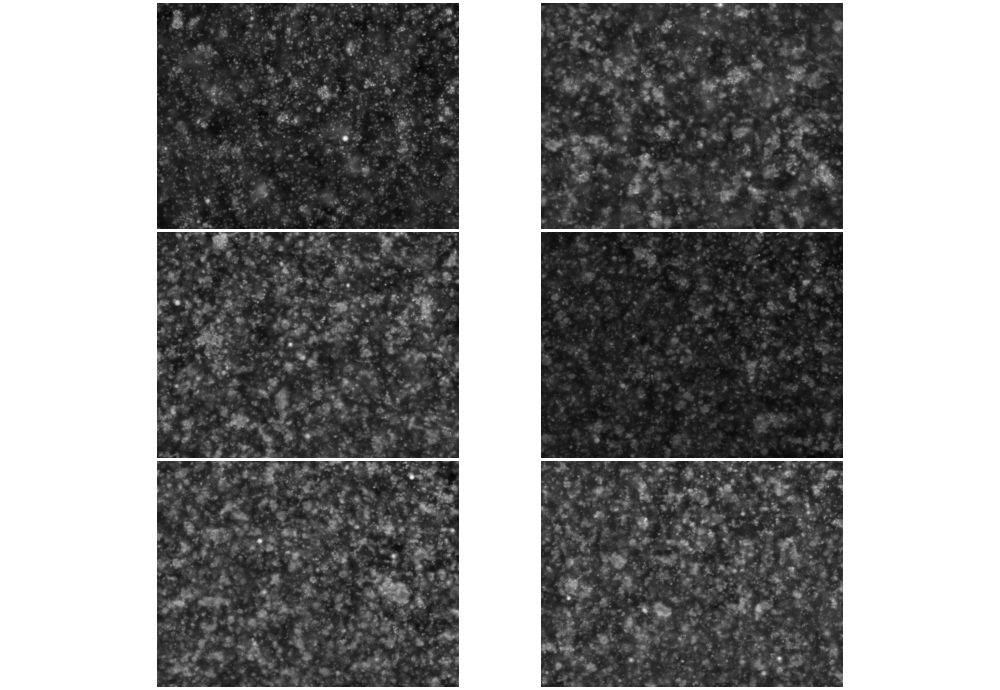

In [16]:
frame_key = 0
### "frame_key" specifies which frame of each tiff file will be analyzed (each frame of my tiff is for a different condition)
### e.g. "key = 0" dictates that the first frame of each tiff file should be analyzed

fsize = 600
### set filter size (pixel area used to estimate and remove average background pixel intensities, recommendation = 600

row = 1
### choose which set of tiff files should be analyzed, row1, row2 or row3

def show_filtered_images(fsize, row, ax, i, frame_key):
    if row == 1:
        index_add = 0
    if row == 2:
        index_add = arr_length
    if row == 3:
        index_add = arr_length * 2
    test_image = tiff_file.imread(files[i+index_add],key=[frame_key])
    #print(files[i+index_add])
    #ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+", fsize="+str(fsize)+")", fontsize=10)
    filtered_image = filtimage(test_image, filtersize= fsize)
    fully_processed_image = downscale_local_mean(filtered_image, (2,2), cval=1)
    ax.imshow(fully_processed_image, cmap = 'gray')
    ax.axis('off')
    plt.tight_layout(pad=.2)

condition = frame_names[frame_key] + ", t = " + str(time_array[i]) + " hrs"
print("condition: "+condition)
i = 0
num_rows = 3#int((len(files)/4)/3) #*2
fig_height = num_rows*2.3
fig, axs = plt.subplots(num_rows, 2, figsize=(10,fig_height))
for j, ax in enumerate(axs.flatten()):
        show_filtered_images(fsize, row, ax, i, frame_key)
        i = i + 8 
plt.title()
plt.show()

### option to save this figure (uncomment below)
#fig.savefig(data_dir2+"raw vs filtered images for "+condition+" (row"+str(row)+", f="+str(fsize)+")"+".jpg", dpi=dpi_num)